# Forecasting Stock Prices with Long-short term memory Neural Network based on Attention Mechanism ###

###### reading the data sets and showing the data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
url="/content/drive/MyDrive/Colab Notebooks/HSI.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002/1/2,11368.12988,11368.12988,11241.62988,11350.84961,11350.84961,106074600
1,2002/1/3,11348.79981,11447.00000,11348.79981,11423.51953,11423.51953,274626200
2,2002/1/4,11547.00977,11727.80957,11547.00977,11702.15039,11702.15039,362553600
3,2002/1/7,11687.42969,11905.54981,11687.42969,11892.63965,11892.63965,442387000
4,2002/1/8,11781.19043,11806.25000,11678.05957,11713.70996,11713.70996,279504600


In [ ]:
df1 = df.reset_index()['Open']  # selecting the opening Price for the prediction

In [ ]:
df1   #all the values are inside the df2

0       11368.12988
1       11348.79981
2       11547.00977
3       11687.42969
4       11781.19043
           ...     
4299    28447.96094
4300    28046.16016
4301    28352.93945
4302    28632.58984
4303    28352.93945
Name: Open, Length: 4304, dtype: float64



#### Now Plotting the Opeing Price with noise

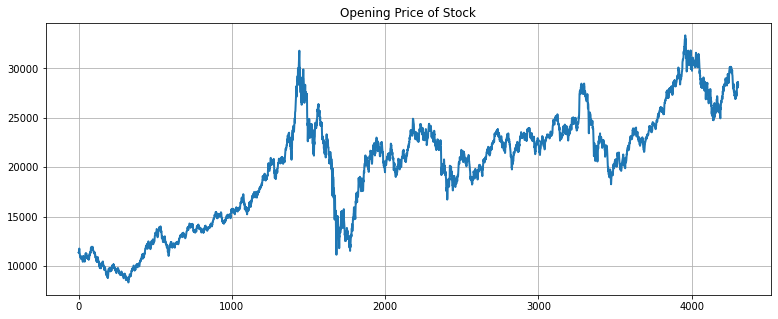

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 5))
plt.plot(df1, linewidth = 2)
plt.title('Opening Price of Stock')
plt.grid()



**Now Ploting the graph with denoising**


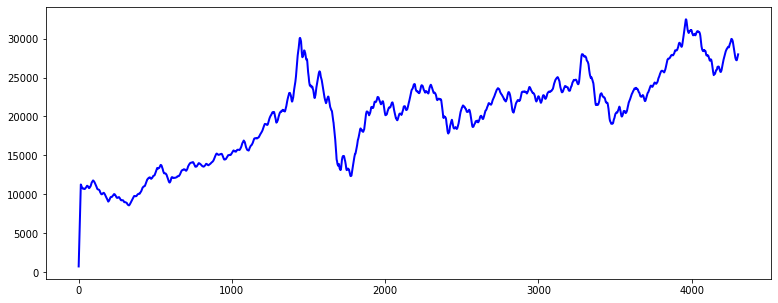

In [ ]:
from scipy.signal import lfilter

n = 15  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
df1 = lfilter(b,a,df1)
plt.figure(figsize = (13, 5))
plt.plot(df1, linewidth=2, c="b")

### LSTM are sensitive to the scale of the data so, we apply minmax scalar

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(4304, 1)

### Spliting the data into train data and test data

In [ ]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size, test_size

(2797, 1507)

In [ ]:
import numpy
#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]  ##0,0,1,2,3,
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#reshape into X=t,t+1,t+2, t+3 and Y = t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test,y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train)

[[0.         0.02386531 0.04814743 ... 0.34691568 0.34594961 0.34474682]
 [0.02386531 0.04814743 0.07272484 ... 0.34594961 0.34474682 0.34394507]
 [0.04814743 0.07272484 0.09749942 ... 0.34474682 0.34394507 0.34315754]
 ...
 [0.65734564 0.65821456 0.65940909 ... 0.6722718  0.67380473 0.67509454]
 [0.65821456 0.65940909 0.66186306 ... 0.67380473 0.67509454 0.67673988]
 [0.65940909 0.66186306 0.66415713 ... 0.67509454 0.67673988 0.67868621]]


In [ ]:
print(X_test.shape), print(y_test.shape)

(1406, 100)
(1406,)


(None, None)

In [ ]:
print(X_train.shape), print(y_train.shape)

(2696, 100)
(2696,)


(None, None)

In [ ]:
#reshape input to be [samples, time_steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

**Creating the LST Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100, batch_size=64, verbose=1)

Epoch 1/100
43/43 [==============================] - 7s 172ms/step - loss: 1.9153e-05 - val_loss: 8.6184e-06
Epoch 2/100
43/43 [==============================] - 7s 171ms/step - loss: 2.8215e-05 - val_loss: 2.0229e-05
Epoch 3/100
43/43 [==============================] - 7s 171ms/step - loss: 1.4748e-05 - val_loss: 1.2678e-05
Epoch 4/100
43/43 [==============================] - 7s 171ms/step - loss: 2.8840e-05 - val_loss: 2.4040e-05
Epoch 5/100
43/43 [==============================] - 7s 171ms/step - loss: 3.0059e-05 - val_loss: 3.8934e-05
Epoch 6/100
43/43 [==============================] - 7s 170ms/step - loss: 1.5221e-05 - val_loss: 2.1044e-05
Epoch 7/100
43/43 [==============================] - 7s 171ms/step - loss: 2.1654e-05 - val_loss: 4.9035e-04
Epoch 8/100
43/43 [==============================] - 7s 171ms/step - loss: 4.6086e-05 - val_loss: 2.1999e-05
Epoch 9/100
43/43 [==============================] - 7s 172ms/step - loss: 2.2426e-05 - val_loss: 1.1599e-04
Epoch 10/100
43/43 

In [ ]:
#lets train predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
#transform to original form
scalar.fit(train_predict)
train_predict = scalar.inverse_transform(train_predict)
scalar.fit(test_predict)
test_predict = scalar.inverse_transform(test_predict)

In [ ]:
#calculate RMSE on performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.08740114301723127

In [ ]:
#calculate RMSE on test data
math.sqrt(mean_squared_error(y_test,test_predict))

0.1393396067657661

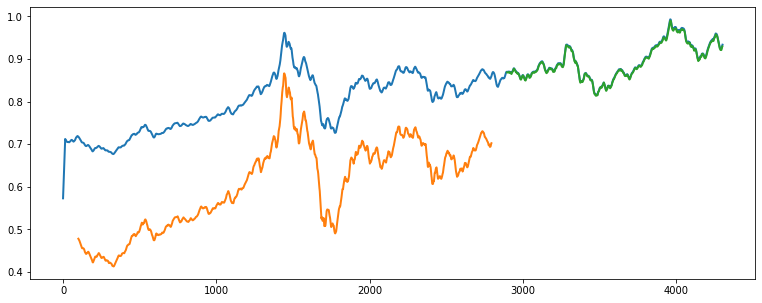

In [ ]:
#shit train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
#shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict
#plot baseline and predictions
plt.figure(figsize = (13, 5))
plt.plot(scalar.inverse_transform(df1),linewidth=2)
plt.plot(trainPredictPlot, linewidth=2)
plt.plot(testPredictPlot,linewidth=2)
plt.show() 